In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

#a) Exploración de Datos

In [14]:
# Cargar dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Ver forma de los datos
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


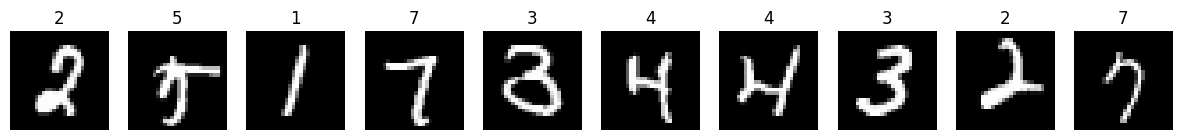

In [15]:
# Elegir 10 índices aleatorios del set de entrenamiento
indices = np.random.choice(len(x_train), 10, replace=False)

# Crear figura
plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    plt.subplot(1, 10, i+1)   # 1 fila, 10 columnas
    plt.imshow(x_train[idx], cmap="gray")
    plt.title(str(y_train[idx]))
    plt.axis("off")

plt.show()

In [16]:
#Las etiquetas que más me convienen acá son binarias, 0 si es par, 1 si es impar

# Etiquetas binarias: 0 si el número es par, 1 si es impar
y_train_bin = y_train % 2
y_test_bin  = y_test % 2

print("Primeras 10 etiquetas originales:", y_train[:10])
print("Primeras 10 etiquetas binarias  :", y_train_bin[:10])


Primeras 10 etiquetas originales: [5 0 4 1 9 2 1 3 1 4]
Primeras 10 etiquetas binarias  : [1 0 0 1 1 0 1 1 1 0]


#b) Pre-Procesamiento

Se crea una clase que permita normalizar las muestras al igual que descartar los features con varianza nula

In [17]:
class Normalizer:
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.valid_features_ = None

    # Etapa de entrenamiento: calcular media y std de cada feature
    def fit(self, X):
        # Media y std de cada columna
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)

        # Guardar solo las features que tienen varianza distinta de 0, de este modo descarto los pixeles innecesarios de las imágenes
        self.valid_features_ = self.std_ > 0

        # Filtrar los valores
        self.mean_ = self.mean_[self.valid_features_]
        self.std_ = self.std_[self.valid_features_]
        return self

    # Aplicar la transformación
    def transform(self, X):
        # Filtrar solo las columnas válidas
        X_valid = X[:, self.valid_features_]

        # Estandarización
        X_scaled = (X_valid - self.mean_) / self.std_
        return X_scaled

    # Entrenar y aplicar
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


Se aplica la normalización y descarte a las muestras

In [18]:
#Aplano las imágenes (de 28x28 a 784 columnas)
X_train = x_train.reshape(x_train.shape[0], -1)  # (60000, 784)
X_test  = x_test.reshape(x_test.shape[0], -1)    # (10000, 784)

print("Shape antes de normalizar:", X_train.shape, X_test.shape)

#Normalizo
scaler = Normalizer()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm  = scaler.transform(X_test)

print("Shape después de normalizar:", X_train_norm.shape, X_test_norm.shape)
print("Media (primeras 5 features):", X_train_norm.mean(axis=0)[:5])
print("Std (primeras 5 features):", X_train_norm.std(axis=0)[:5]) #Si esta todo ok, esto debería de darme un vector de unos

#La shape después de normalizar debería de darme con menos columnas, por los valores filtrados

Shape antes de normalizar: (60000, 784) (10000, 784)
Shape después de normalizar: (60000, 717) (10000, 717)
Media (primeras 5 features): [ 2.96059473e-19  1.77635684e-18 -2.33886984e-18 -2.93098879e-18
 -1.53950926e-18]
Std (primeras 5 features): [1. 1. 1. 1. 1.]


#C) Análisis Teórico:

La función sigmoide σ(z) se define como:
$$σ(z)=\frac{1}{1+e^-z}$$

Para calcular la función inversa $σ^-1(p)$, se plantea:
$$p = \frac{1}{1+e^-z} ⇒1+ e^-z=\frac{1}{p}⇒z=-ln(\frac{1}{p}-1)$$
$$\therefore σ^-1(p)=-ln(\frac{1}{p}-1)$$



Luego, se calcula la derivada de p=σ´(z):
$$\frac{dp}{dz}=\frac{e^-z}{(1+e^-z)^2}$$
Si se reemplza z con $z=-ln(\frac{1}{p}-1)$:
$$\frac{dp}{dz}=(\frac{1}{p}-1).p^2=p-p^2$$
$$\therefore σ´(z)=p-p^2$$

Como $Y$ es una variable Bernoulli, es suficiente con estimar $p(x)=P_{Y|X=x}(1)$, ya que $p(x)=P_{Y|X=x}(0)=1-p(x)$ se puede calcular por el complemento.

Para garantizar que dicha estimación hecha se encuentre en el intervalo (0, 1) se modela $\hat{p}(x)=σ(w^{T}x + b)$ con $wϵℜ^{dx}$,$bϵℜ$ y σ(z) la función sigmoide.

Durante el entrenamiento se define a la función costo la definimos como $\ell(x,y)=\hat{P}(y|x)$, por lo tanto, la función costo tendrá la forma:

\begin{equation}
\ell(x,y) =
\begin{cases}
 -\ln \big( 1 - \sigma(w^{T}x + b) \big) & \text{si } y = 0 \\[6pt]
 -\ln \big( \sigma(w^{T}x + b) \big) & \text{si } y = 1
\end{cases}
\end{equation}

\begin{equation}
\ell(x,y) = -(1-y)\ln \big( 1 - \sigma(w^{T}x + b) \big) - y \ln \big( \sigma(w^{T}x + b) \big)
\end{equation}

y sus derivadas pueden calcularse a partir de la regla de la cadena como:

\begin{equation}
\frac{\partial \ell(x,y)}{\partial w}
= x\,\sigma(w^T x + b)\big(1-\sigma(w^T x + b)\big)
\left( \frac{1-y}{1-\sigma(w^T x + b)} - \frac{y}{\sigma(w^T x + b)} \right)
\end{equation}

\begin{equation}
= x\Big( \sigma(w^T x + b)(1-y) - y(1-\sigma(w^T x + b)) \Big)
\end{equation}

\begin{equation}
= x\big(\sigma(w^T x + b) - y\big)
\end{equation}

\begin{equation}
\frac{\partial \ell(x,y)}{\partial b}
= \sigma(w^T x + b)\big(1-\sigma(w^T x + b)\big)
\left( \frac{1-y}{1-\sigma(w^T x + b)} - \frac{y}{\sigma(w^T x + b)} \right)
\end{equation}

\begin{equation}
= \sigma(w^T x + b) - y
\end{equation}



#d) Regresión Logística

Se crea una clase que sea una regresión logística binaria, utilizando gradiente descendiente

In [19]:
class RegresionLogistica:
    def __init__(self, learning_rate, n_iterations, patience=None, min_delta=0.001, verbose=False):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.cte = 1e-6
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.loss_historial = []

    def _sigmoid(self, z):
        # Estable numéricamente para ambos casos z ≷ 0
        return np.where(z >= 0,
                        1.0 / (1.0 + np.exp(-z)),
                        np.exp(z) / (1.0 + np.exp(z)))

    # Etapa de entrenamiento
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        best_loss = np.inf # Arranco asumiendo que mi loss es infinita, asi cualquier resultado que obtenga resultará menor al inicial
        patience_counter = 0 # Es un contador de cuántas iteraciones llevo sin mejorar mi loss

        for i in range(self.n_iterations):
            linear_model = X @ self.weights + self.bias
            y_predicted = self._sigmoid(linear_model)
            dw = (1 / n_samples) * (X.T @ (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Calcular loss y guardarla
            current_loss = self.cross_entropy(X, y)
            self.loss_historial.append(current_loss)

            # Compruebo si hay que hacer un early stop
            if self.patience is not None:
                if current_loss < best_loss - self.min_delta:
                    best_loss = current_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        if self.verbose:
                            print("Se detuvieron las iteraciones")
                        break


    # Etapa de testeo soft (se calcula indirectamente la probabilidad de ser par)
    def predict_proba(self, X):
        linear_model = X @ self.weights + self.bias
        y_predicted = self._sigmoid(linear_model)
        return y_predicted

    # Etapa de testeo hard (se "truncan" las probabilidades)
    def predict(self, X):
        y_predicted = self.predict_proba(X)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    # Accuracy, básicamente la probabilidad de éxito
    def accuracy(self, X, y):
        y_predicted = self.predict(X)
        accuracy = np.sum(y_predicted == y) / len(y)
        return accuracy

    #Cross-Entropy
    def cross_entropy(self, X, y):
        y_predicted = self.predict_proba(X)
        # Hay que agregar una cte para que evitar el caso del log(0)
        loss = -np.mean(y * np.log(y_predicted + self.cte) + (1 - y) * np.log(1 - y_predicted + self.cte))
        return loss

Se entrena el modelo con un $learning$ $rate$ y un número de iteraciones que otorguen buenos resultados

In [ ]:
l_rate = 0.04
n_iter = 700
y_train_binary = (y_train % 2 == 0).astype(int)
y_test_binary = (y_test % 2 == 0).astype(int)

model_binary = RegresionLogistica(learning_rate=l_rate, n_iterations=n_iter)
model_binary.fit(X_train_norm, y_train_binary)

iters = np.arange(1, len(model_binary.loss_historial) + 1)

plt.figure()
plt.plot(iters, model_binary.loss_historial)
plt.xlabel("Iteración")
plt.ylabel("Riesgo (Cross-Entropy)")
plt.title("Evolución del riesgo durante el entrenamiento")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()

In [ ]:
# Reportar el accuracy y la cross entropy de entrenamiento y testeo.
# Calculo las métricas de entrenamiento
train_accuracy_binary = model_binary.accuracy(X_train_norm, y_train_binary)
train_cross_entropy_binary = model_binary.cross_entropy(X_train_norm, y_train_binary)

print("Accuracy de entrenamiento de la clasificación Paridad:", train_accuracy_binary)
print("Cross-Entropy de entrenamiento de la clasificación Paridad:", train_cross_entropy_binary)

# Calculo las métricas de testeo
test_accuracy_binary = model_binary.accuracy(X_test_norm, y_test_binary)
test_cross_entropy_binary = model_binary.cross_entropy(X_test_norm, y_test_binary)

print("Accuracy de testeo de la clasificación Paridad:", test_accuracy_binary)
print("Cross-Entropy de testeo de la clasificación Paridad:", test_cross_entropy_binary)

In [ ]:
# Predecir las etiquetas binarias para el dataset de testeo
y_predict_binary = model_binary.predict(X_test_norm)

# Muestro imagenes de testeo y las etiquetas predichas
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()

# Genero 10 indices aleatorios para extraer del test set
rnd_index = np.random.choice(len(x_test), size=10, replace=False)
x_test_random = x_test[rnd_index]
y_pred_random = y_predict_binary[rnd_index]

for i, ax in enumerate(axes):
    ax.imshow(x_test_random[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'({y_test[rnd_index[i]]}) Paridad: {bool(y_pred_random[i])}')

plt.tight_layout()
plt.show()

In [ ]:
# Calculo TPR y FPR para varios umbrales
y_scores = model_binary.predict_proba(X_test_norm) # Probabilidades de ser par
y_true = y_test_binary # etiquetas reales (0 si es par, 1 impar)
# Ordeno
y_true_sorted = y_true[np.argsort(y_scores)]
y_scores_sorted = y_scores[np.argsort(y_scores)]
# Uso los valores que se repiten como umbrales
thresholds = np.unique(y_scores_sorted) #Conjunto de todos los valores únicos que predijo mi modelo

tpr_list = []
fpr_list = []
cte = 1e-8

# Calculo el total de instancias positivas (1 es par)
tot_positivos = np.sum(y_true) # cant de nros pares en el test set
tot_negativos = len(y_true) - tot_positivos # cant de impares en el test set


for threshold in thresholds:
    # Clasifico las muestras según el umbral
    y_predicted_binary = (y_scores_sorted >= threshold).astype(int)

    # Calculo TP, FP para este umbral
    TP = np.sum((y_predicted_binary == 1) & (y_true_sorted == 1))
    FP = np.sum((y_predicted_binary == 1) & (y_true_sorted == 0))

    # Calculo TPR y FPR
    # Agrego la cte para no dividr por 0
    tpr = TP / (tot_positivos + cte)
    fpr = FP / (tot_negativos + cte)

    tpr_list.append(tpr)
    fpr_list.append(fpr)

# Ordeno para luego graficar
sorted_indices = np.argsort(fpr_list)
fpr_sorted = np.array(fpr_list)[sorted_indices]
tpr_sorted = np.array(tpr_list)[sorted_indices]

# Agrego los puntos (0,0) y (1,1)
if fpr_sorted[0] > 0 or tpr_sorted[0] > 0:
    fpr_sorted = np.insert(fpr_sorted, 0, 0)
    tpr_sorted = np.insert(tpr_sorted, 0, 0)

if fpr_sorted[-1] < 1 or tpr_sorted[-1] < 1:
     fpr_sorted = np.append(fpr_sorted, 1)
     tpr_sorted = np.append(tpr_sorted, 1)

In [ ]:
# Curva ROC ploteada
plt.figure(figsize=(6, 6))
plt.plot(fpr_sorted, tpr_sorted, color='navy', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.scatter(0, 1, color='green', label='Perfect Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()